In [1]:
!pip install -q transformers
!pip install -q gradio
!pip install -q timm
!pip install -q inflect
!pip install -q phonemizer
!sudo apt-get update
!sudo apt-get install espeak-ng
!pip install -q py-espeak-ng

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.8/857.8 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 854.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.2 MB

In [16]:
import io
import matplotlib.pyplot as plt
import requests
import inflect
from PIL import Image

def load_image_from_url(url):
    return Image.open(requests.get(url, stream=True).raw)

def render_results_in_image(in_pil_img, in_results):
    plt.figure(figsize=(16, 10))
    plt.imshow(in_pil_img)

    ax = plt.gca()

    for prediction in in_results:

        x, y = prediction['box']['xmin'], prediction['box']['ymin']
        w = prediction['box']['xmax'] - prediction['box']['xmin']
        h = prediction['box']['ymax'] - prediction['box']['ymin']

        ax.add_patch(plt.Rectangle((x, y),
                                   w,
                                   h,
                                   fill=False,
                                   color="green",
                                   linewidth=2))
        ax.text(
           x,
           y,
           f"{prediction['label']}: {round(prediction['score']*100, 1)}%",
           color='red'
        )

    plt.axis("off")

    # Save the modified image to a BytesIO object
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png',
                bbox_inches='tight',
                pad_inches=0)
    img_buf.seek(0)
    modified_image = Image.open(img_buf)

    # Close the plot to prevent it from being displayed
    plt.close()

    return modified_image

def summarize_predictions_natural_language(predictions):
    summary = {}
    p = inflect.engine()

    for prediction in predictions:
        label = prediction['label']
        if label in summary:
            summary[label] += 1
        else:
            summary[label] = 1

    result_string = "In this image, there are "
    for i, (label, count) in enumerate(summary.items()):
        count_string = p.number_to_words(count)
        result_string += f"{count_string} {label}"
        if count > 1:
          result_string += "s"

        result_string += " "

        if i == len(summary) - 2:
          result_string += "and "

    # Remove the trailing comma and space
    result_string = result_string.rstrip(', ') + "."

    return result_string


In [31]:
from transformers import pipeline
import os
import gradio as gr

from IPython.display import Audio as IPythonAudio

In [9]:
od_pipe = pipeline("object-detection", "facebook/detr-resnet-50")

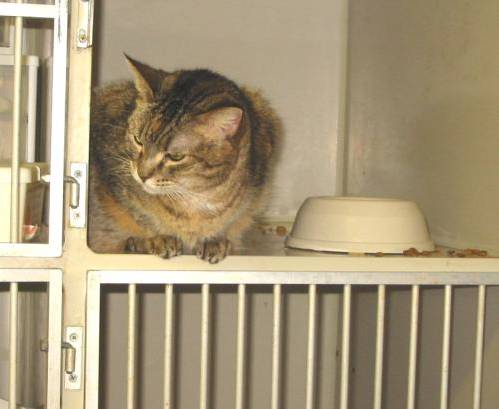

In [33]:
raw_image = Image.open("/content/cat.1123.jpg")
raw_image.resize((569, 491))
raw_image

In [34]:
output = od_pipe(raw_image)
output

[{'score': 0.9987395405769348,
  'label': 'cat',
  'box': {'xmin': 85, 'ymin': 51, 'xmax': 285, 'ymax': 262}},
 {'score': 0.9834344387054443,
  'label': 'bowl',
  'box': {'xmin': 284, 'ymin': 195, 'xmax': 438, 'ymax': 251}}]

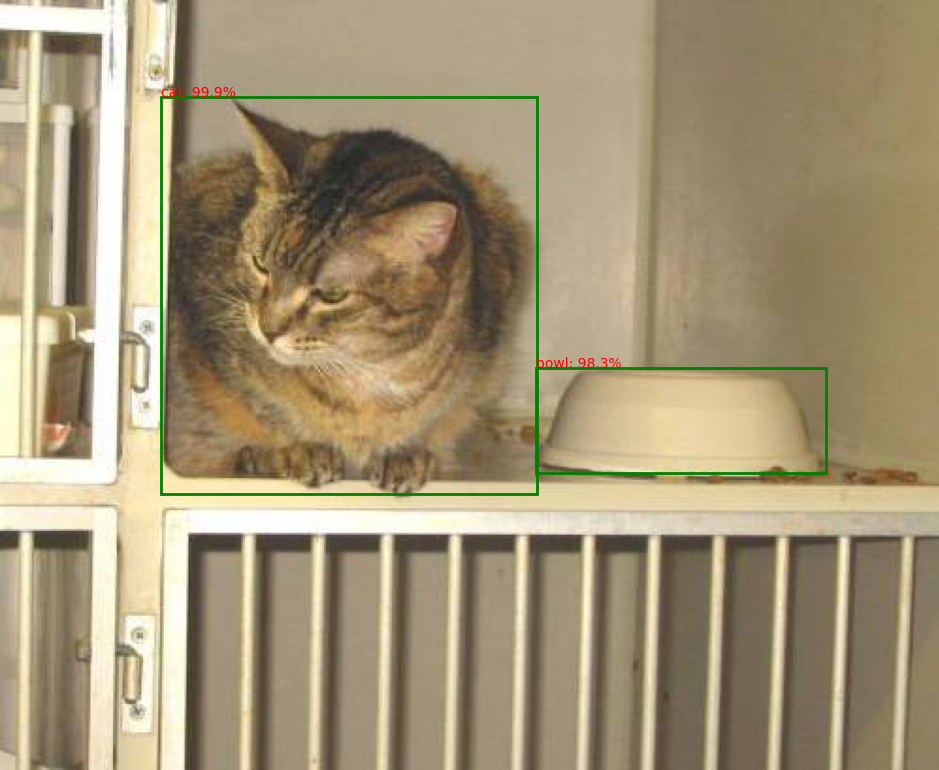

In [35]:
processed_image = render_results_in_image(
    raw_image,
    output
)

processed_image

## **Build an App using Gradio**

In [19]:
def get_pipeline_prediction(pil_image):
    pipeline_output = od_pipe(pil_image)
    processed_image = render_results_in_image(pil_image, pipeline_output)
    return processed_image

In [20]:
demo = gr.Interface(
  fn=get_pipeline_prediction,
  inputs=gr.Image(label="Input image", type="pil"),
  outputs=gr.Image(label="Output image with predicted instances", type="pil")
)

In [21]:
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://1de5a00dc65f5732bf.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [22]:
demo.close()

Closing server running on port: 7860


## **Build an AI powered Audio Assistant**

Explain the detected objects in the image.

In [36]:
output

[{'score': 0.9987395405769348,
  'label': 'cat',
  'box': {'xmin': 85, 'ymin': 51, 'xmax': 285, 'ymax': 262}},
 {'score': 0.9834344387054443,
  'label': 'bowl',
  'box': {'xmin': 284, 'ymin': 195, 'xmax': 438, 'ymax': 251}}]

In [37]:
od_pipe

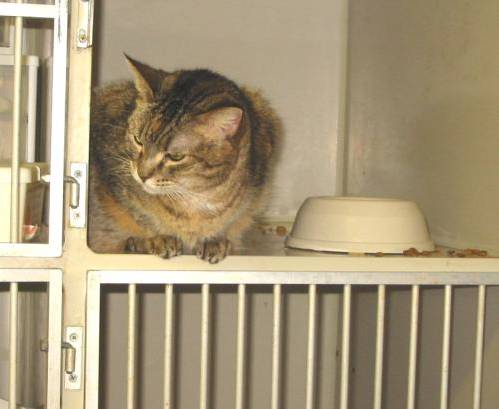

In [38]:
raw_image

In [39]:
text = summarize_predictions_natural_language(output)
text

'In this image, there are one cat and one bowl.'

In [40]:
tts_pipe = pipeline("text-to-speech", model="kakao-enterprise/vits-ljs")
tts_pipe

In [41]:
narrated_text = tts_pipe(text)
narrated_text

{'audio': array([[-0.00115008, -0.00135592, -0.00163612, ...,  0.00052516,
          0.00042849,  0.00040465]], dtype=float32),
 'sampling_rate': 22050}

In [42]:
IPythonAudio(narrated_text["audio"][0], rate=narrated_text["sampling_rate"])